In [203]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm_notebook as tqdm 

os.listdir('../input')

['test', 'train.csv', 'sample_submission.csv']

## <center> Preparing Data

The standard deviation with a window size of 4000 points is used as the base function.

In [204]:
CHUNCK_SIZE = 40000000
N_SMOOTH_POINTS = 4000

In [205]:
def feature_extractor(x):
    return np.std(x)

In [206]:
x, y = [], []
for train in tqdm(pd.read_csv('../input/train.csv', 
                                   dtype={'acoustic_data': np.int16, 'time_to_failure': np.float16}, 
                                   chunksize=CHUNCK_SIZE)):
    for i in range(N_SMOOTH_POINTS, len(train), N_SMOOTH_POINTS):
        x.append(feature_extractor((train.iloc[i-N_SMOOTH_POINTS: i, 0].values)))
        y.append(np.mean(train.iloc[i-N_SMOOTH_POINTS: i, 1].values))

## <center> Failure Detection

Failure detection algorithm based on calculation gradient and choices threshold for finding outliers, which is failure.

In [208]:
from sklearn.base import BaseEstimator

class FailureDetector(BaseEstimator):
    def __init__(self, window_size=3, 
                 dtime=1.5, 
                 delay=3,
                 init_thr=-100,
                 max_itr=100,
                 use_bias=False,
                 verbose=1):
        self.window_size = window_size
        self.dtime=dtime
        self.delay = delay
        self.thr = init_thr
        self.b = 0
        self.verbose = verbose
        self.max_itr = max_itr
        self.use_bias = use_bias
    
    def fit(self, x, y):
        _y = np.where((np.array(y)[1:] - np.array(y)[:-1]) > self.dtime)[0]
        peaks = self.uniques(_y, self.delay)
        
        n_peaks = len(peaks)
        _error = n_peaks
        itr = 0
        while _error != 0 and itr < self.max_itr:
            _p = np.where(self.feature(x, self.window_size) < self.thr)[0]
            _peaks = self.uniques(_p, self.delay)
            itr += 1
            _error = n_peaks - len(_peaks)
            if self.verbose == 1:
                print(f'Iter:{itr}; Thr: {self.thr}; Error: {_error}')
            if abs(_error) > 0:
                self.thr += 10*_error/abs(_error)
            
        self.b = np.mean(peaks - _peaks)
        
    def predict(self, x):
        peaks = np.where(self.feature(x, self.window_size) < self.thr)[0]
        peaks = self.uniques(peaks, self.delay).astype(np.float64)
        if self.use_bias:
            peaks += self.b
        return np.floor(peaks).astype(int)
        
    @staticmethod
    def uniques(x, delay):
        peaks = [0]
        for j in range(len(x)):
            if x[j] - peaks[-1] > delay:
                peaks.append(x[j])
        peaks.pop(0)
        return np.array(peaks)
    
    @staticmethod
    def feature(x, size):
        new_x = np.zeros_like(x)
        for i in range(1, len(x)):
            new_x[i] = x[i-size if i-size > 0 else 0] - x[i]
        return new_x

In [209]:
x, y = np.array(x), np.array(y)

In [210]:
%%time
fd = FailureDetector(verbose=0)
fd.fit(x, y)
failure = fd.predict(x)

CPU times: user 3.55 s, sys: 8 ms, total: 3.56 s
Wall time: 3.56 s


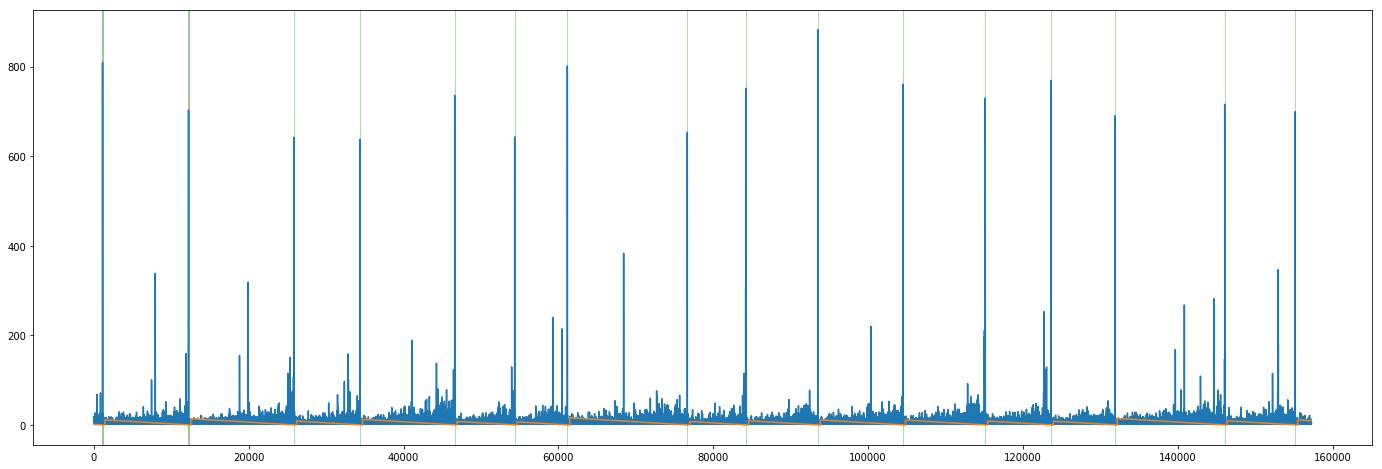

In [211]:
fig, ax = plt.subplots(1, 1, figsize=(24,8))

ax.plot(x)
ax.plot(np.array(y))
for f in failure:
    plt.axvspan(f-10, f+10, alpha=0.3, color='g')
fig.savefig('train_failures.png');

At the plot above can be counted 16 failures.

## <center> How much failures in test data?...

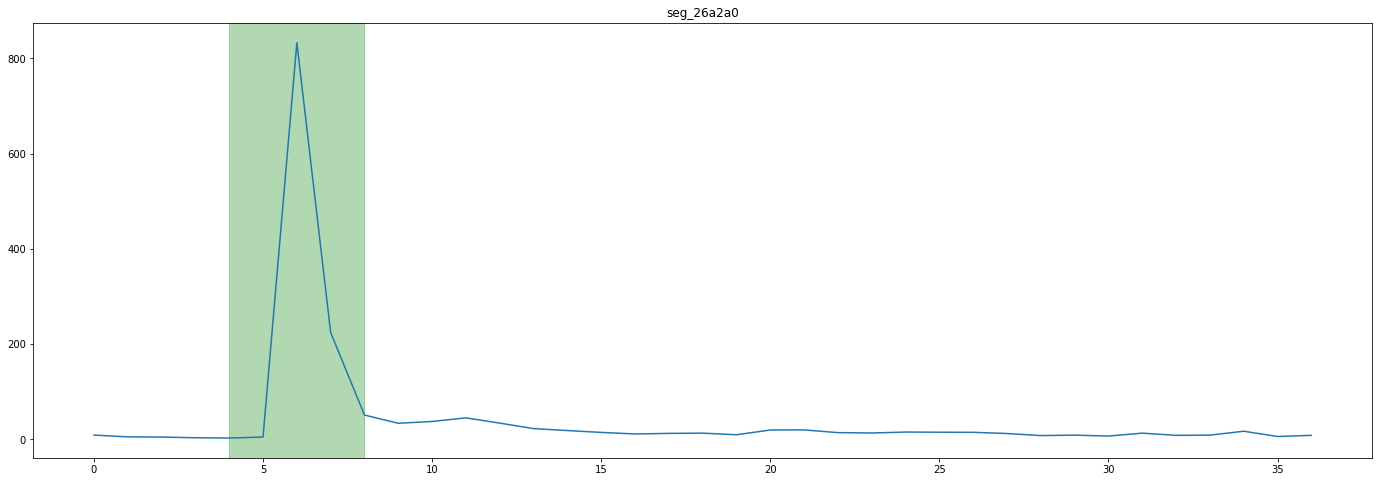

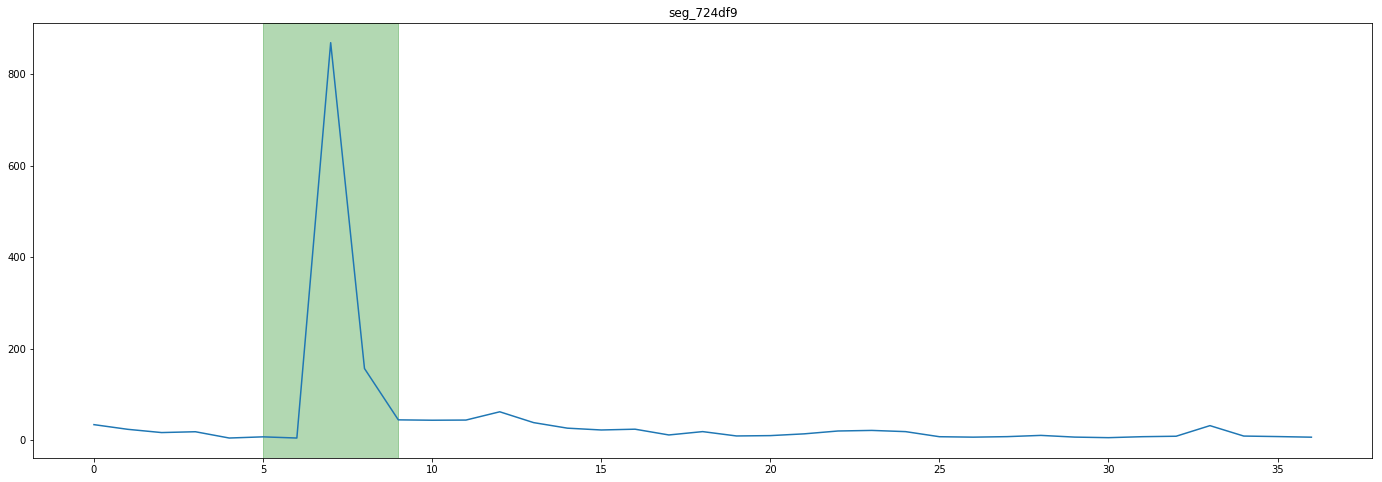

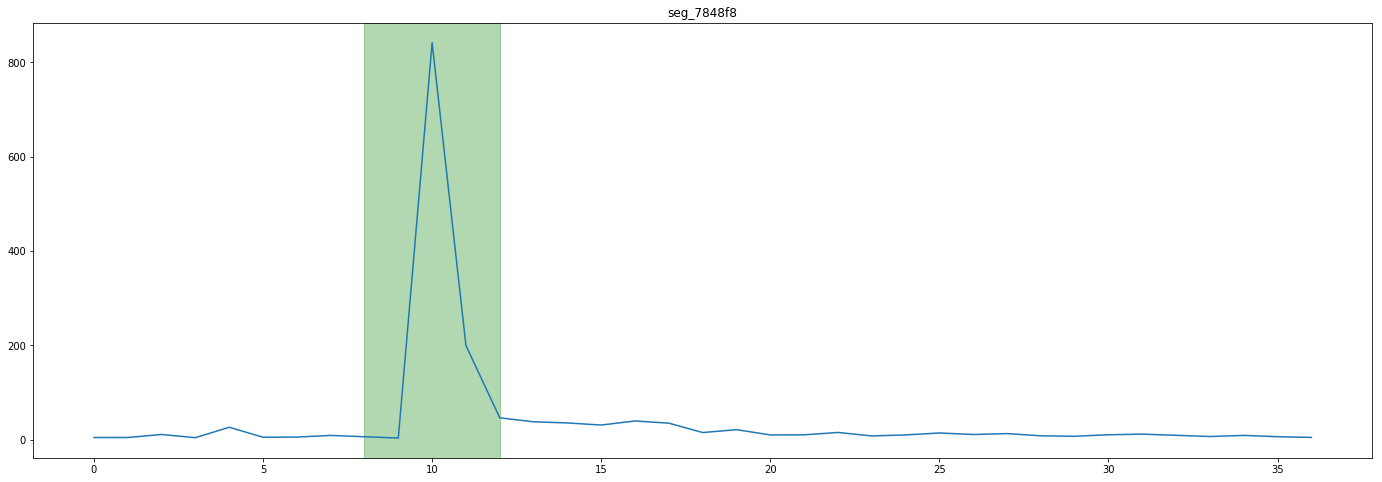

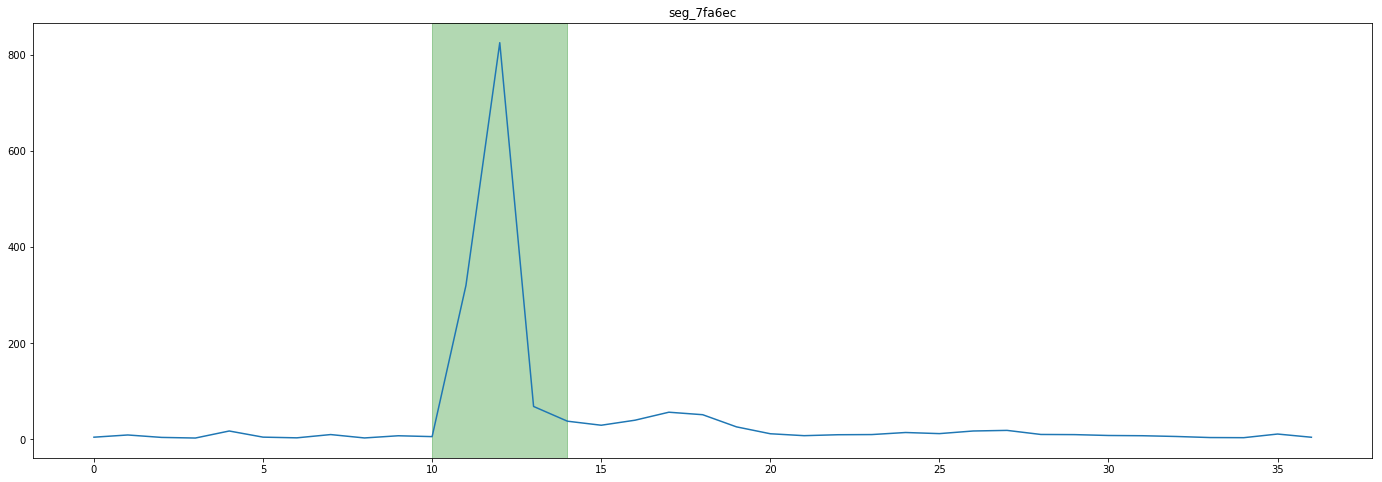

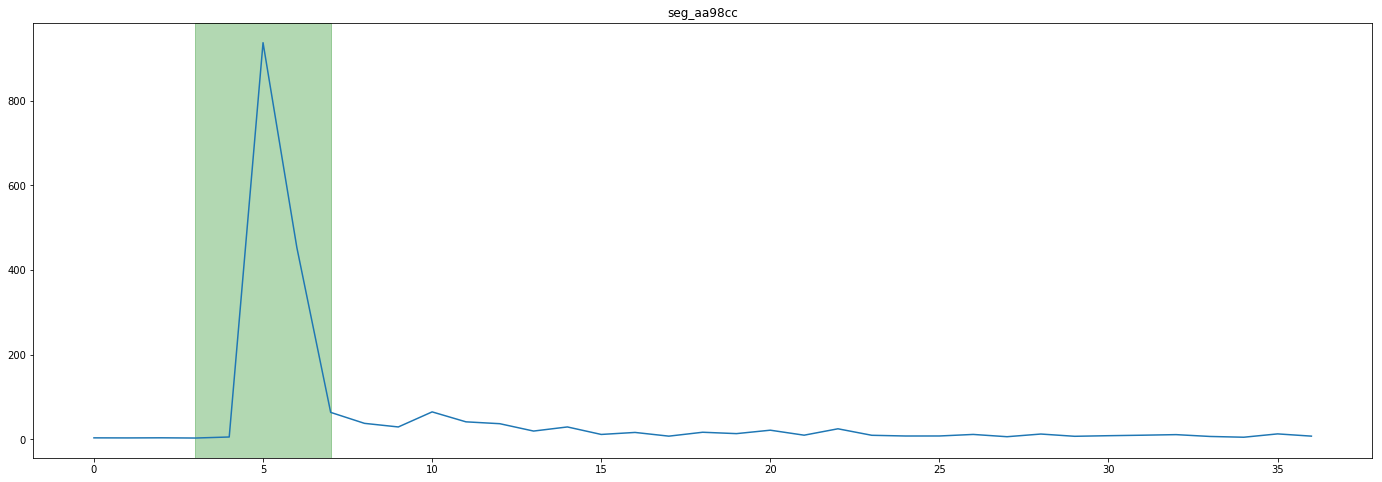

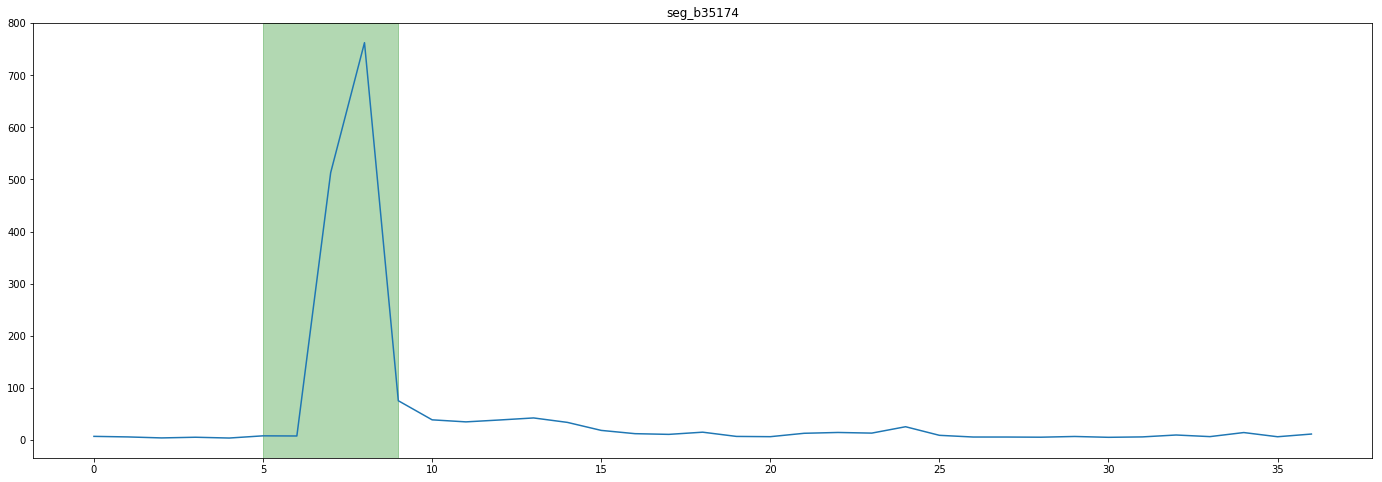

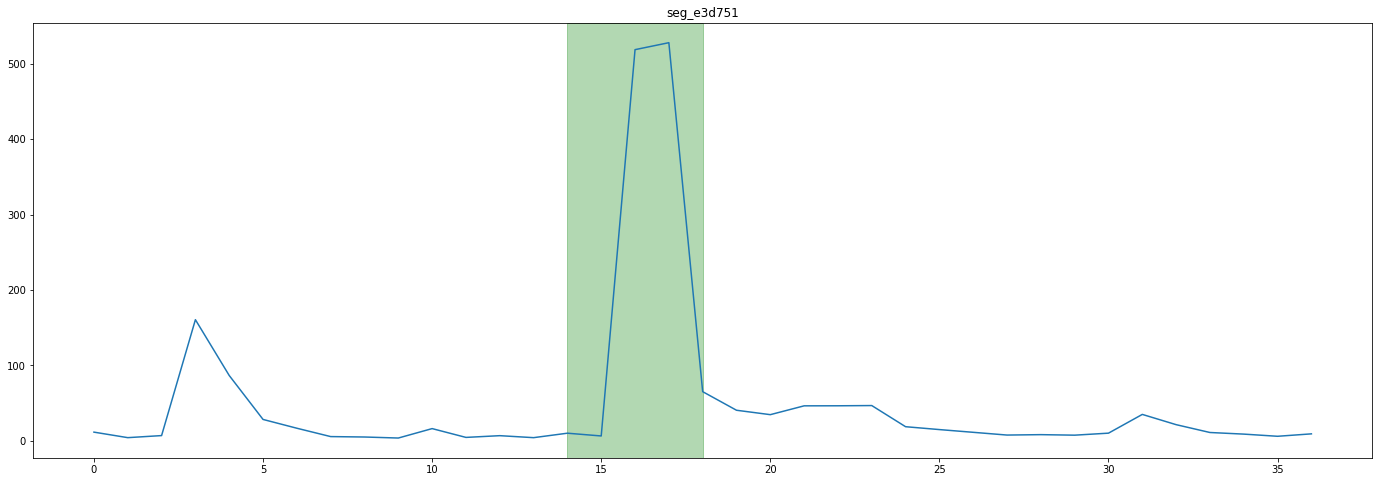

In [212]:
submission = pd.read_csv('../input/sample_submission.csv', index_col='seg_id')
for seg_id in tqdm(submission.index):
    seg = pd.read_csv('../input/test/' + seg_id + '.csv')
    x_seg = []
    for i in range(N_SMOOTH_POINTS, len(seg), N_SMOOTH_POINTS):
        x_seg.append(feature_extractor((seg.iloc[i-N_SMOOTH_POINTS: i, 0].values)))
    x_seg = np.array(x_seg)
    failure = fd.predict(x_seg)
    
    if len(failure) > 0:
        fig, ax = plt.subplots(1, 1, figsize=(24,8))

        ax.plot(x_seg)
        for f in failure:
            plt.axvspan(f-2, f+2, alpha=0.3, color='g')
        plt.title(f'{seg_id}')
        plt.show()
        fig.savefig(f'{seg_id}.png')

Hmm ... This algorithm detected <b> 7 </b> failures, which are visualized in the graphs above.